# Conexión a Google Drive

El primer paso es obtener acceso al almacenamiento para la práctica. Utilizaremos un directorio ubicado en nuestro Google Drive, por ejemplo `"GIA/VCA/P0/"`.

En primer lugar, conectamos el notebook con nuestro Google Drive. Ejecutamos `drive.mount` con una ruta y nos pedirá autorización para acceder a los contenidos. 


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Después podemos cambiar el directorio de trabajo a la ruta del proyecto, como `"GIA/VCA/P0/"` en nuestro Drive. Esto nos permitirá utilizar rutas relativas para acceder a nuestros datos y guardar resultados.


In [ ]:
route = '/content/gdrive/MyDrive/GIA/VCA/P0'

print("Current directory:")
!pwd

print(f"\nWe now change the directory to '{route}'")
%cd $route
!pwd

print("\nAnd here there are our files:")
!ls -lasth



# Cargar un dataset de torchvision

La biblioteca torchvision contiene varios [datasets de imágenes](https://pytorch.org/vision/stable/datasets.html) listos para usar. Nosotros cargaremos y utilizaremos el dataset de clasificación de dígitos [MNIST](https://pytorch.org/vision/stable/datasets.html#mnist).

La API permite descargarlo directamente en una ruta determinada. Utilizaremos el directorio del proyecto que hemos almacenado en la variable `route`.

In [1]:
from torchvision import datasets

train = datasets.MNIST(".",train=True)
test = datasets.MNIST(".",train=False)

Ahora el conjunto de datos está listo para usarse a partir de los objetos `test` y `train`, que son una subclase de [Dataset](https://pytorch.org/docs/stable/data.html#map-style-datasets), y definirá una función *pythonic* [`__getitem__()`](https://docs.python.org/3.7/reference/datamodel.html#object.__getitem__) que permita iterar sobre él, y normalmente una [`__len__()`](https://docs.python.org/3.7/reference/datamodel.html#object.__len__) que permite obtener su tamaño.

In [2]:
print(train)
print(test)


Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
Dataset MNIST
    Number of datapoints: 10000
    Root location: .
    Split: Test


10000
(<PIL.Image.Image image mode=L size=28x28 at 0x12CC4A0D0>, 7)


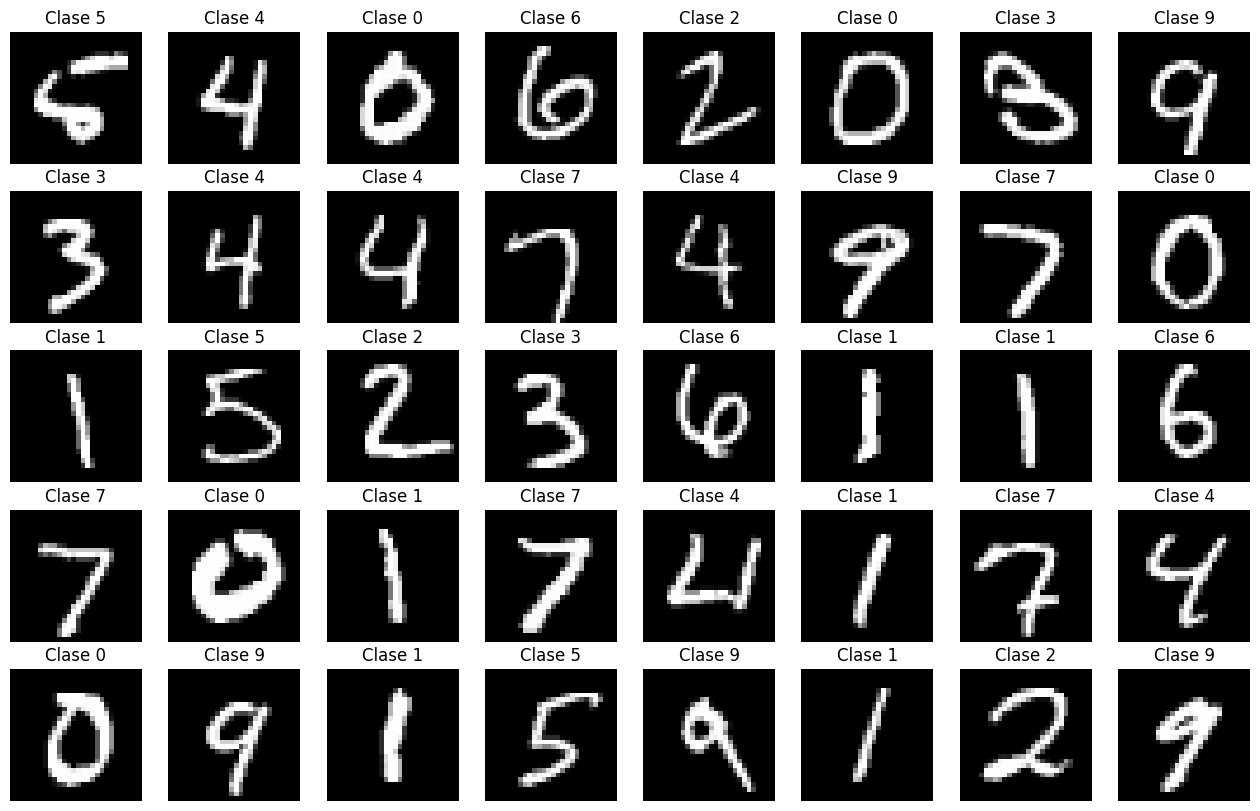

In [3]:
import matplotlib.pyplot as plt
from numpy import random


print(len(test))
print(test[0])

cols, rows = 8, 5
figure = plt.figure(figsize=(cols*2, rows*2))
view = random.permutation(cols * rows)

for i in range(1, cols * rows + 1):
    sample, label = test[view[i-1]]
    figure.add_subplot(rows, cols, i)
    plt.title(f'Clase {label}')
    plt.axis("off")
    plt.imshow(sample, cmap="gray")
plt.show();



# Carga de un modelo de torchvision



Torchvision también contiene varios [modelos de arquitecturas de red](https://pytorch.org/vision/stable/models.html) con los pesos preentrenados y listos para usar. Cargaremos y utilizaremos el modelo [VGG-16](https://pytorch.org/vision/stable/models.html#id2), que está preentrenado en el dataset ImageNet.

También podemos cargar el modelo con pesos aleatorios.

In [4]:
from torchvision import models

vgg = models.vgg16(weights=True)

/Users/pepe/carrera/3/2/vca/vca/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Ahora podemos explorar, modificar y utilizar el modelo cargado.

Este modelo se compone de bloques de dos/tres capas [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d) 3x3 de N canales, seguidos de activación [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU), y una capa final [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d) que divide la imagen por 2. Hay 5 bloques de este tipo, con número de canales duplicado desde N=64 hasta N=512. El bloque convolucional se almacena en un módulo [Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential) llamado `features`.

La cabeza del clasificador también se almacena en un módulo [Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential) (`classifier`). El modelo espera un vector de entrada de 25.088 características, que resulta de aplicar el módulo de características a una imagen de 128x128 (512x7x7). Este modelo se compone de varias capas [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) totalmente conectadas, seguidas de activación [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) y [Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#torch.nn.Dropout). La capa de salida es una capa [Lineal](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) totalmente conectada con 1000 salidas de clase.

Además, esta implementación de PyTorch ofrece las siguientes características:

* Una capa [AddaptiveAvgPool2d](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html#torch.nn.AdaptiveAvgPool2d) 7x7 entre la capa convolucional `features` y la capa `classifier` totalmente conectada. Esto permite tener 512x7 características. Por lo tanto, no importa si la imagen de entrada es mayor que 128x128.
* La capa de salida es lineal, lo que proporciona los logits de salida para 1000 clases. Para obtener una probabilidad de clasificación debemos añadir una capa [SoftMax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html#torch.nn.Softmax) o una capa [SoftMax2d](https://pytorch.org/docs/stable/generated/torch.nn.Softmax2d.html#torch.nn.Softmax2d) encima.

In [5]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Podemos probar la red con imágenes del conjunto de datos MNIST que hemos cargado. No se espera nada útil, ya que la red está entrenada en ImageNet.

Sin embargo, esta red espera imágenes RGB de 128x128, y las imágenes MNIST son de 1 canal y 28x28 píxeles. Vamos a redimensionar las imágenes a 128x128 y convertirlas a RGB usando la librería [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html).


This is the dataset 'input'
<PIL.Image.Image image mode=L size=28x28 at 0x13EF7B450>

This is the transformed 'input'
torch.Size([1, 3, 128, 128])

This is the output of the network
torch.Size([1, 1000])


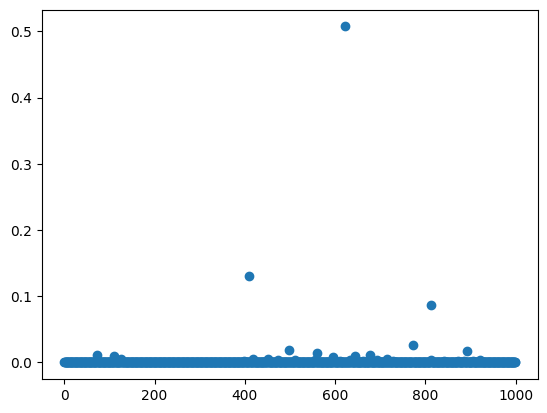

In [6]:
from torchvision import transforms as t
from scipy.special import softmax

trans = t.Compose([
                   t.Lambda(lambda x: x.convert("RGB")),
                   t.Resize(128),
                   t.ToTensor()
])

input, target = test[0]
print("This is the dataset 'input'")
print(input)

input = trans(input).unsqueeze_(0) 
# The unsqueeze is because the network need an input of [N,3,W,H], 
# where N is the number of training/testing images: in this case 1.
# The transform output will be a PyTorch tensor of shape [3,128,128].
# The unsqueeze gives a tensor of shape [1,3,128,128].

print("\nThis is the transformed 'input'")
print(input.shape)

output = vgg(input)

print("\nThis is the output of the network")
print(output.shape)

import matplotlib.pyplot as plt

#plt.scatter([range(len(output.detach().numpy()[0]))], output.detach().numpy()[0])
plt.scatter([range(len(output.detach().numpy()[0]))], softmax(output.detach().numpy()[0]))

In [7]:
len(output.detach().numpy())

1

#  Adaptar el modelo cargado

En este caso modificaremos el modelo para clasificar 10 dígitos. Se aplica una operación de pooling a la salida del bloque convolucional y se añade una capa totalmente conectada de 10 neuronas como salida de la clasificación. 

In [8]:
from torch import nn

vggf = vgg.features

mymodel = nn.Sequential(
    vggf,
    nn.AdaptiveAvgPool2d(output_size = 1),
    nn.Flatten(),
    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.Linear(1024, 10),
)

output = mymodel(input)
print(output.shape)



torch.Size([1, 10])


Adicionalmente adaptaremos el número de canales de entrada a 1. Inicializando los nuevos kernels de nivel de gris como la suma a lo largo de los canales de los kenels RGB en la red pre-entrenada.




In [9]:
print(mymodel[0][0])
for name, param in mymodel[0][0].named_parameters():
  print(f"- {name}: {param.shape}")

old_layer = mymodel[0][0]
mymodel[0][0] = nn.Conv2d(1, 64, 3, padding=1)
# print(dir(old_layer.weight)) virgen santa
mymodel[0][0].weight.data = old_layer.weight.sum(dim=1, keepdim=True)
mymodel[0][0].bias.data = old_layer.bias

print(mymodel[0][0])
for name, param in mymodel[0][0].named_parameters():
  print(f"- {name}: {param.shape}")


Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
- weight: torch.Size([64, 3, 3, 3])
- bias: torch.Size([64])
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
- weight: torch.Size([64, 1, 3, 3])
- bias: torch.Size([64])


# Crear un modelo desde cero

Para definir un nuevo modelo desde cero es conveniente definir una subclase de nn.Module.

Sólo necesitamos definir el constructor y el método `forward`. El método backward se calcula automáticamente usando `autograd` a partir del grafo de ejecución.



In [10]:
class myCNN(nn.Module):
    
    def __init__(self):
        super(myCNN, self).__init__()
        
        self.convlayer1 = nn.Sequential(
            nn.Conv2d(1,32,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.convlayer2 = nn.Sequential(
            nn.Conv2d(32,64,3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(64*6*6,600), # We assume the 6x6 resulting from input images of 28x28
            nn.ReLU()
            )

        self.fc2 = nn.Linear(120, 10)
        
    def forward(self, x):
        x = self.convlayer1(x)
        x = self.convlayer2(x)
        x = x.view(-1,64*6*6) # Like flattening in-place
        x = self.fc1(x)
        x = self.fc2(x)
        return nn.log_softmax(x,dim=1)

Ahora podemos hacer una instancia de este modelo y jugar con él.

Ten en cuenta que las capas se inicializarán con los parámetros aleatorios por defecto, que se pueden cambiar por aproximaciones definidas por el usuario. Por ejemplo, para las capas convolucionales activadas con ReLU, es más conveniente utilizar la inicialización [Kaiming He Uniform](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_uniform_), pero para las capas TanH es mejor seguir la de [Xavier Glorot](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.xavier_uniform_).

In [ ]:
mycnn = myCNN()

print(mycnn)

# Carga de datos para el entrenamiento





Los [Datasets](https://pytorch.org/vision/stable/datasets.html#mnist) de PyTorch permiten añadir un conjunto de [transforms](https://pytorch.org/vision/stable/transforms.html) que deben aplicarse a los datos.

In [11]:
mytransforms = t.Compose([
                          t.Resize(64),
                          t.ToTensor(),
                          t.Normalize((0.5,),(0.5,))
])

test = datasets.MNIST('.', train=False, download=True, transform = mytransforms)

Las transformaciones del dataset pueden ser aleatorias, de modo que cada vez que el dataset devuelve una imagen determinada, se aplica una transformación aleatoria. Esto puede utilizarse para aumentar los datos en línea durante el entrenamiento.

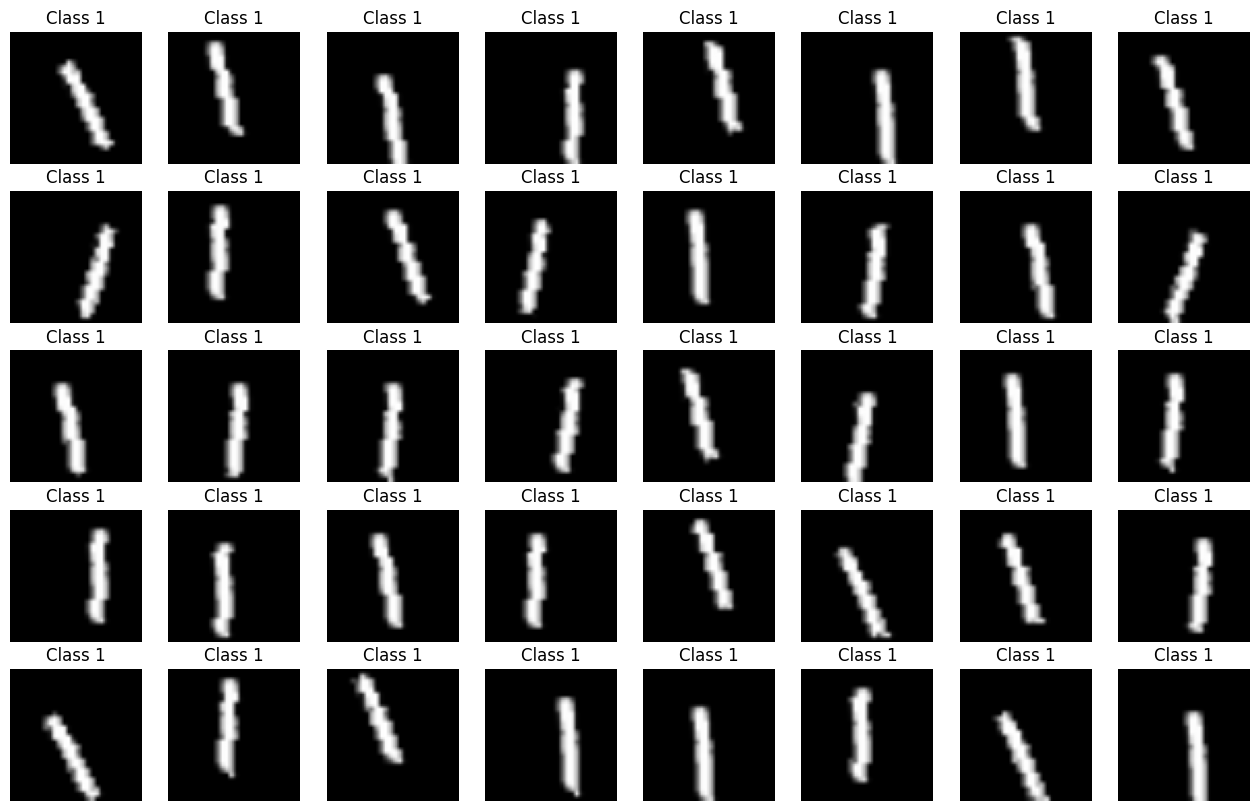

In [57]:
myaugmentation = t.Compose([
                             #t.Pad(3),
                             t.RandomAffine(degrees=20, translate=(0.15, 0.15), shear=10),
                             mytransforms
])

train = datasets.MNIST('.', train=True, download=True, transform=myaugmentation)

sample_idx = random.randint(0, len(train))
cols, rows = 8, 5

fig, axes = plt.subplots(rows, cols,figsize =(cols*2, rows*2) )

# Loading the same sample over and over again gives different transforms
for axrow in axes:
  for ax in axrow:
    sample,label = train[sample_idx]
    ax.imshow(sample[0], cmap='gray')
    ax.axis('off')
    ax.title.set_text(f'Class {label}')



Además, es conveniente acceder a los conjuntos de datos mediante un [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader). Esto permitirá cargar los datos de forma aleatoria y por lotes, listos para ser utilizados por la red. 

In [ ]:
from torch.utils.data import DataLoader

dataloader = DataLoader(train, batch_size=128, shuffle=True, num_workers=2)

#We can iterate over the dataset as:
counter = 0
for sample, target in dataloader:
  print(f"Minibacth {counter}: ({sample.shape}, {target.shape}).")
  counter += 1
  if counter == 10:
    print("... It would continue for much longer until an epoch is completed.")
    break
  

# Entrenamiento de la red

PyTorch incluye un motor de diferenciación automática [autograd](https://pytorch.org/docs/stable/autograd.html). Esto permite calcular fácilmente los gradientes de retropropagación. 


In [ ]:
# Autograd Example. Make two tensors and operate with them
import torch

a = torch.tensor([1., 2.], requires_grad=True)
b = torch.tensor([5., 6.], requires_grad=True)

# Look at the current gradients
print(f"Tensor 'a': {a}")
print(f"Gradients wrt tensor 'a': {a.grad}")

print(f"Tensor 'b': {b}")
print(f"Gradients wrt tensor 'b': {b.grad}")

# Pass it through the "network"

q = 3*a**3-b**2           # 3a^3-b^2 -> dq/da = 9a^2 ; dq/db = -2b

print(f"Tensor 'q': {q}")
print(f"Tensor 'q.sum()': {q.sum()}")


# Compute the backpropagation gradients, first integrating all the q outputs

q.sum().backward()

print(f"After backpropagation:")
print(f"Gradients wrt tensor 'a': {a.grad}; Theoretical gradients: {9*a**2}")
print(f"Gradients wrt tensor 'b': {b.grad}; Theoretical gradients: {-2*b}")



Para completar un bucle de optimización necesitamos una red, una función de pérdida a partir de la cual retropropagar (usaremos la [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)) y también necesitamos un [Optimizer](https://pytorch.org/docs/stable/optim.html), como [Adam](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam), o [SGD](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD), para actualizar los pesos.

También es conveniente utilizar la GPU. Para ello, asegúrate de que la máquina virtual de Colab tiene la GPU habilitada en `Runtime>Change runtime type>Hardware accelaration>GPU`. Además necesitamos cargar los tensores en el dispositivo GPU. Este es un bucle de entrenamiento mínimo:






In [ ]:
from torch import optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
mymodel.to(device)                     # Place the model into the GPU

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mymodel.parameters(), lr=1e-4)  # Intizalize the optimizer with the network parameters and learning rate

for epoch in range(3):                            # Iterate a given number of epochs, or control with another condition
  for i,data in enumerate(dataloader):            # Iterate over the batches in the dataset
    samples = data[0].to(device)                  # Place the data into the GPU
    targets = data[1].to(device)                  # Place the targets into the GPU

    output = mymodel(samples)                     # Compute the training samples output
    loss = criterion(output, targets)             # Compute the loss

    optimizer.zero_grad()                         # Reset the old gradients accumulated in the buffer from previous iteration
    loss.backward()                               # Backpropagate the error, which accumulates the gradients for the batch
    optimizer.step()                              # Update the model parameters, according to the optimizer rule

    #if i%200 == 0:
    _, predicted = torch.max(output,1)
    total = targets.size(0)
    correct = (predicted == targets).sum().item()
    print(f"epoch:{epoch}, mini-batch: {i}: Training loss: {loss.item()}, accuracy: {correct/total}")


# Test de la red

Una vez entrenada la red, podemos realizar un bucle similar para agregar algunas métricas sobre el conjunto de test. Por ejemplo:


In [ ]:
def accuracy(outputs, targets):
    _, predicted = outputs.max(1)
    total = targets.size(0)
    correct = (predicted == targets).sum().item()
    return correct/total

testloader = DataLoader(test, batch_size=128, shuffle=False, num_workers=2)

mymodel.eval() #  This notifies all the layers in the model to put themselves 
             # into evaluation mode, just in case there are some with different 
             # behaviour during training and testing

mean_acc = 0
with torch.no_grad(): # This disables autograd
  for i, (samples, targets) in enumerate(testloader):
    samples = samples.to(device)
    targets = targets.to(device)

    outputs = mymodel(samples)
    
    this_acc = accuracy(outputs, targets)
    mean_acc += this_acc

  mean_acc /= (i+1)

print(f"Model accuracy on the test set is {mean_acc*100} %")

# Frameworks y utilidades 

Aunque PyTorch es lo suficientemente flexible como para diseñar los bucles de entrenamiento y evaluación a voluntad, es conveniente tratar de estructurar tus rutinas de entrenamiento y evaluación en funciones y scripts personalizados que puedan ser fácilmente reutilizados y mantenidos. 

A veces es conveniente utilizar bibliotecas externas que definan un marco de entrenamiento y evaluación para controlar el bucle de entrenamiento con las mejores prácticas estándar.

Esto, sin embargo, requerirá cierta curva de aprendizaje adicional, y a veces es conveniente afrontar los problemas a mano antes de indagar en una solución enlatada (aunque flexible).

Algunos ejemplos de frameworks de entrenamiento:

* [PyTorch ignite](https://pytorch.org/ignite/): [notebook de ejemplo MNIST](https://colab.research.google.com/github/pytorch/ignite/blob/5e6a629566c411d85a2184ae748cb0312e159150/examples/notebooks/FashionMNIST.ipynb)
* [PyTorch lightning](https://www.pytorchlightning.ai/): [notebook de ejemplo MNIST](https://colab.research.google.com/github/PyTorchLightning/pytorch-lightning/blob/fe0d08899eba94d275ff42253f495d9e70d86f89/notebooks/01-mnist-hello-world.ipynb)